In [1]:
import re
import string

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import texthero as hero
from bs4 import BeautifulSoup
from imblearn.under_sampling import RandomUnderSampler
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import f1_score
from sklearn.naive_bayes import MultinomialNB
from wordcloud import STOPWORDS, WordCloud
%matplotlib inline

In [2]:
train = pd.read_csv("./input/train_data.csv")
test = pd.read_csv("./input/test_data.csv")
all_df = pd.concat([train, test], ignore_index=True)

In [3]:
stop = set(stopwords.words("english"))
punctuation = list(string.punctuation)
org_stop = ["Subject"]

add_stop = punctuation + org_stop
stop.update(add_stop)

In [4]:
custom_pipeline = [
    hero.preprocessing.remove_stopwords,
    hero.preprocessing.remove_html_tags,
    hero.preprocessing.remove_urls,
    hero.preprocessing.remove_brackets,
    hero.preprocessing.remove_punctuation,
    hero.preprocessing.remove_whitespace,
    hero.preprocessing.lowercase,
    hero.preprocessing.remove_diacritics,
]

train["contents"] = hero.clean(train["contents"], custom_pipeline)

In [5]:
train["contents"] = train["contents"].str[8:]

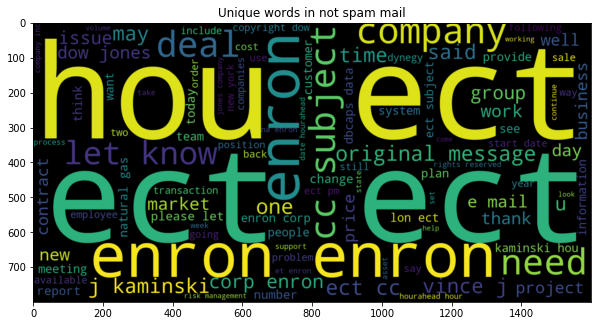

In [6]:
plt.figure(figsize=(10, 10))
wc = WordCloud(max_words=100, width=1600, height=800, stopwords=STOPWORDS).generate(" ".join(train[train.y == 0].contents))
plt.title("Unique words in not spam mail")
plt.imshow(wc, interpolation="bilinear")

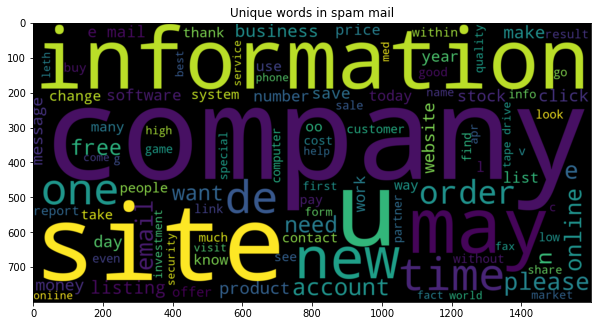

In [7]:
plt.figure(figsize=(10, 10))
wc = WordCloud(max_words=100, width=1600, height=800, stopwords=STOPWORDS).generate(" ".join(train[train.y == 1].contents))
plt.title("Unique words in spam mail")
plt.imshow(wc, interpolation="bilinear")

In [8]:
train["length"] = train["contents"].apply(len)
train.head()

,id,contents,y,length
0,1,fw willis phillips spoke lavo said thing plann...,0,270
1,2,factor loadings primary curves tanya went comp...,0,913
2,3,meridian phone kate symes bill done mid aftern...,0,268
3,4,october wellhead vance deal 420022 created ent...,0,452
4,5,california 6 13 executive summary cpuc rules s...,0,2075


In [9]:
train.groupby("y")['length'].mean()

y
0    1108.932238
1     829.087719
Name: length, dtype: float64

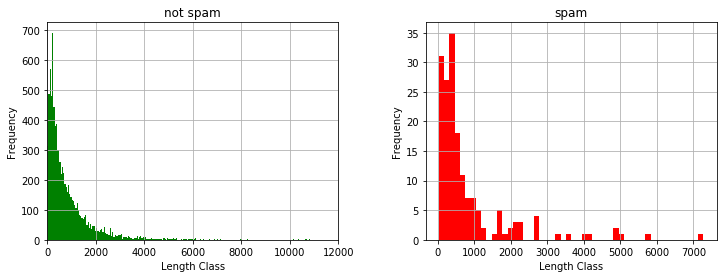

In [10]:
fig,ax = plt.subplots(1,2,figsize=(12,4))

train[train["y"]==0].hist(column="length", bins=2500, ax=ax[0], color = "green")
ax[0].set(xlabel = "Length Class", ylabel = "Frequency", title = "not spam")
ax[0].set_xlim([0,12000])

train[train["y"]==1].hist(column="length", bins=50, ax=ax[1], color = "red")
ax[1].set(xlabel = "Length Class", ylabel = "Frequency", title = "spam")

plt.show()

In [11]:
train["words"] = train["contents"].str.split().map(lambda x: len(x))
train.head()

,id,contents,y,length,words
0,1,fw willis phillips spoke lavo said thing plann...,0,270,45
1,2,factor loadings primary curves tanya went comp...,0,913,138
2,3,meridian phone kate symes bill done mid aftern...,0,268,43
3,4,october wellhead vance deal 420022 created ent...,0,452,83
4,5,california 6 13 executive summary cpuc rules s...,0,2075,289


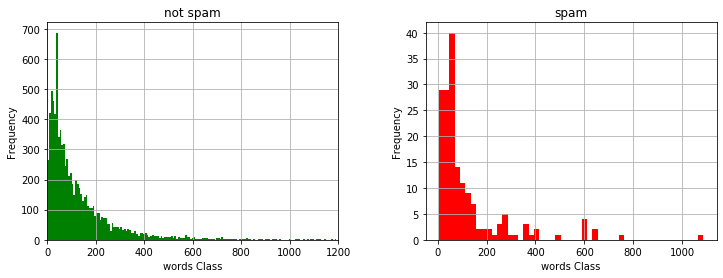

In [12]:
fig,ax = plt.subplots(1,2,figsize=(12,4))

train[train["y"]==0].hist(column="words", bins=2500, ax=ax[0], color = "green")
ax[0].set(xlabel = "words Class", ylabel = "Frequency", title = "not spam")
ax[0].set_xlim([0,1200])

train[train["y"]==1].hist(column="words", bins=50, ax=ax[1], color = "red")
ax[1].set(xlabel = "words Class", ylabel = "Frequency", title = "spam")

plt.show()

In [13]:
train.groupby("y")["words"].mean()

y
0    167.170093
1    120.269006
Name: words, dtype: float64

In [14]:
X = pd.DataFrame(train["contents"])
y = pd.DataFrame(train["y"])

In [15]:
seed = [i for i in range(5)]
preds = []

for i in seed:
    # アンダーサンプリングしながら訓練用データの作成
    sampler = RandomUnderSampler(random_state=i)
    X_resampled, y_resampled = sampler.fit_resample(X,y)
    
    # 検証用データの作成（random_stateを変えて取得）
    sampler = RandomUnderSampler(random_state=i+10)
    X_val, y_val = sampler.fit_resample(X,y)
    
    # 単語の出現回数取得
    vec_count = CountVectorizer(min_df=3)
    vec_count.fit(X_resampled['contents'])

    # 単語の種類の表示
    print('word size: ', len(vec_count.vocabulary_))
    # 先頭５件の単語を表示
    print('word content: ', dict(list(vec_count.vocabulary_.items())[0:5]))
    
    # 訓練データと検証データをベクトル化
    X_resampled_vec = vec_count.transform(X_resampled['contents'])
    X_val_vec = vec_count.transform(X_val["contents"])
    
    # ベルヌーイモデルで学習
    model = MultinomialNB()
    model.fit(X_resampled_vec, y_resampled['y'])
    
    # F1スコアのprint
    print("val_F1-score",f1_score(model.predict(X_val_vec),y_val))
    print("------------------------------------------------------------------------------------------------------------------")
    
    # testデータをベクトル化
    df_data = pd.DataFrame(test, columns=['contents'])
    input_vec = vec_count.transform(df_data['contents'])

    # testの予測→seed毎に空のリストに格納
    pred = model.predict(input_vec)
    preds.append(pred)

word size:  2476
word content:  {'request': 1877, 'submitted': 2164, 'access': 121, 'manfred': 1337, 'enron': 770}
val_F1-score 0.9657142857142856
------------------------------------------------------------------------------------------------------------------
word size:  2190
word content:  {'denver': 566, 'meeting': 1224, 'vince': 2108, 'went': 2138, 'interesting': 1008}
val_F1-score 0.9768786127167629
------------------------------------------------------------------------------------------------------------------
word size:  2888
word content:  {'planning': 1944, 'energy': 943, 'finance': 1093, 'class': 570, 'presentation': 1998}
val_F1-score 0.9497206703910615
------------------------------------------------------------------------------------------------------------------
word size:  2707
word content:  {'start': 2335, 'date': 688, '12': 19, '25': 48, '01': 3}
val_F1-score 0.9659090909090909
----------------------------------------------------------------------------------------

In [16]:
# 予測結果を多数決
prediction = stats.mode(preds)[0]

# spam判定数を確認
# test全体で17000とのこと
prediction.sum()

16675